# Development of PyTorch Geometric model

I'll use this notebook to play with and develop the code for the GNN implementation based on the pytorch_geometric library.

## References

PyTorch Geometric documentation:
http://rusty1s.github.io/pytorch_geometric

MetaLayer documentation: https://rusty1s.github.io/pytorch_geometric/build/html/modules/nn.html#torch_geometric.nn.meta.MetaLayer

## Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torch_geometric
from torch_geometric.nn import MetaLayer
from torch_scatter import scatter_add
from torch_sparse import coalesce

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Define a simple GNN layer

I'm going to try something which differs from the documentation. I'm going to try and define the edge and node parts as individual modules, and then a graph layer module which wraps those, then a GNN model which loops over graph layers.

In [3]:
class GNN(nn.Module):
    """A simple graph network"""
    
    def __init__(self, input_node_dim, input_edge_dim,
                 hidden_node_dim, hidden_edge_dim, 
                 n_graph_iters=1):
        super(GNN, self).__init__()
        self.n_graph_iters = n_graph_iters
        
        # The node encoder transforms input node features to the hidden space
        self.node_encoder = nn.Sequential(
            nn.Linear(input_node_dim, hidden_node_dim),
            nn.ReLU()
        )
        # Similarly, the edge encoder transforms input edge features to hidden space
        self.edge_encoder = nn.Sequential(
            nn.Linear(input_edge_dim, hidden_edge_dim),
            nn.ReLU()
        )
        # The edge network computes new edge features
        self.edge_network = nn.Sequential(
            nn.Linear(2*hidden_node_dim + hidden_edge_dim, hidden_edge_dim),
            nn.ReLU(),
            nn.Linear(hidden_edge_dim, hidden_edge_dim),
            nn.ReLU()
        )
        # The node network computes new node features
        self.node_network = nn.Sequential(
            nn.Linear(hidden_node_dim + hidden_edge_dim, hidden_node_dim),
            nn.ReLU(),
            nn.Linear(hidden_node_dim, hidden_node_dim),
            nn.ReLU()
        )
        # The edge classifier computes final edge scores
        self.edge_classifier = nn.Sequential(
            nn.Linear(2*hidden_node_dim + hidden_edge_dim, hidden_edge_dim),
            nn.ReLU(),
            nn.Linear(hidden_edge_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, data):
        # Make every edge bi-directional
        send_idx = torch.cat([data.edge_index[0], data.edge_index[1]], dim=0)
        recv_idx = torch.cat([data.edge_index[1], data.edge_index[0]], dim=0)

        # Encode the graph features into the hidden space
        x = self.node_encoder(data.x)
        e = self.edge_encoder(data.edge_attr)
        e = torch.cat([e, e], dim=0) # bi-directional

        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Compute new edge features
            edge_inputs = torch.cat([x[send_idx], x[recv_idx], e], 1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
            aggr_inputs = scatter_add(e, recv_idx, dim=0)

            # Compute new node features
            node_inputs = torch.cat([x, aggr_inputs], 1)
            x = self.node_network(node_inputs)

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = data.edge_index
        e = e[:start_idx.shape[0]]
        clf_inputs = torch.cat([x[start_idx], x[end_idx], e], dim=1)
        return self.edge_classifier(clf_inputs).squeeze(-1)

## Create some dummy graph data

In [4]:
def dummy_graph(n_nodes, node_dim, edge_dim):    
    # Connect every node together
    edge_index = torch.tensor([[i, j] for i in range(0, n_nodes) 
                               for j in range(i+1, n_nodes)]).t()
    n_edges = edge_index.shape[1]
    # Generate node and edge features
    x = torch.randn(n_nodes, node_dim)
    e = torch.randn(n_edges, edge_dim)
    # Construct the graph
    return torch_geometric.data.Data(x=x, edge_index=edge_index, edge_attr=e)

class DummyDataset(Dataset):
    
    def __init__(self, n_samples, n_nodes, node_dim, edge_dim):
        super(DummyDataset, self).__init__()
        self.graphs = [dummy_graph(n_nodes, node_dim, edge_dim) for i in range(n_samples)]
    
    def __getitem__(self, index):
        return self.graphs[index]
    
    def __len__(self):
        return len(self.graphs)

def draw_graph(data):
    plt.figure()
    plt.scatter(data.x[:,0], data.x[:,1])
    for start, end in zip(*data.edge_index):
        plt.plot([data.x[start, 0], data.x[end, 0]],
                 [data.x[start, 1], data.x[end, 1]])

In [5]:
# Dummy data config
n_nodes = 4
node_dim = 2
edge_dim = 3

In [6]:
data = dummy_graph(n_nodes, node_dim, edge_dim)

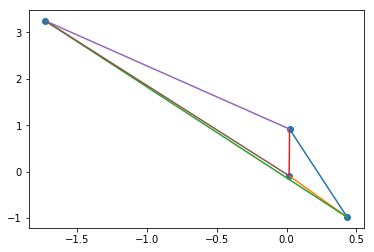

In [7]:
draw_graph(data)

## Test the model on some data

In [8]:
# Model config
hidden_node_dim = 16
hidden_edge_dim = 16

In [9]:
model = GNN(input_node_dim=node_dim, input_edge_dim=edge_dim,
            hidden_node_dim=hidden_node_dim, hidden_edge_dim=hidden_edge_dim)

In [10]:
print(model)
print('Parameters:', sum(p.numel() for p in model.parameters()))

GNN(
  (node_encoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
  )
  (edge_encoder): Sequential(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): ReLU()
  )
  (edge_network): Sequential(
    (0): Linear(in_features=48, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
  )
  (node_network): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
  )
  (edge_classifier): Sequential(
    (0): Linear(in_features=48, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
Parameters: 2769


In [11]:
model(data)

tensor([0.4955, 0.4995, 0.4957, 0.5004, 0.4930, 0.4937],
       grad_fn=<SqueezeBackward1>)

## Test data loader

PyTorch geometric provides some dataset utilities, including a custom data loader. However, I don't think these add sufficient value to use them. I can just use the collate function from the data loader class and do everything else the way I normally would.

In [12]:
# Dataset config
data_config = dict(n_samples=32, n_nodes=8, node_dim=2, edge_dim=3)

In [13]:
dataset = DummyDataset(**data_config)

In [14]:
from torch_geometric.data import Batch

# Create a data loader
collate_fn = Batch.from_data_list
loader = DataLoader(dataset, batch_size=2, collate_fn=collate_fn)

In [15]:
for data in loader:
    break

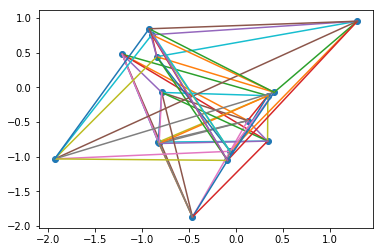

In [16]:
draw_graph(data)

In [17]:
model(data).shape

torch.Size([56])

## Try to reproduce my attention GNN model in this style

In [18]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation=nn.Tanh):
        super(EdgeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            hidden_activation(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            hidden_activation(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            hidden_activation(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())
    def forward(self, x, edge_index):
        # Select the features of the associated nodes
        start, end = edge_index
        x1, x2 = x[start], x[end]
        edge_inputs = torch.cat([x[start], x[end]], dim=1)
        return self.network(edge_inputs).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation=nn.Tanh):
        super(NodeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*3, output_dim),
            nn.LayerNorm(output_dim),
            hidden_activation(),
            nn.Linear(output_dim, output_dim),
            nn.LayerNorm(output_dim),
            hidden_activation(),
            nn.Linear(output_dim, output_dim),
            nn.LayerNorm(output_dim),
            hidden_activation(),
            nn.Linear(output_dim, output_dim),
            nn.LayerNorm(output_dim),
            hidden_activation())

    def forward(self, x, e, edge_index):
        start, end = edge_index
        # Aggregate edge-weighted incoming/outgoing features
        mi = scatter_add(e[:, None] * x[start], end, dim=0, dim_size=x.shape[0])
        mo = scatter_add(e[:, None] * x[end], start, dim=0, dim_size=x.shape[0])
        node_inputs = torch.cat([mi, mo, x], dim=1)
        return self.network(node_inputs)

class GNNSegmentClassifier(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, input_dim=3, hidden_dim=8, n_iters=3, hidden_activation=nn.Tanh):
        super(GNNSegmentClassifier, self).__init__()
        self.n_iters = n_iters
        # Setup the input network
        self.input_network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            hidden_activation())
        # Setup the edge network
        self.edge_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim,
                                        hidden_activation)
        # Setup the node layers
        self.node_network = NodeNetwork(input_dim+hidden_dim, hidden_dim,
                                        hidden_activation)

    def forward(self, inputs):
        """Apply forward pass of the model"""
        # Apply input network to get hidden representation
        x = self.input_network(inputs.x)
        # Shortcut connect the inputs onto the hidden representation
        x = torch.cat([x, inputs.x], dim=-1)
        # Loop over iterations of edge and node networks
        for i in range(self.n_iters):
            # Apply edge network
            e = self.edge_network(x, inputs.edge_index)
            # Apply node network
            x = self.node_network(x, e, inputs.edge_index)
            # Shortcut connect the inputs onto the hidden representation
            x = torch.cat([x, inputs.x], dim=-1)
        # Apply final edge network
        return self.edge_network(x, inputs.edge_index)

## Turning my hitgraph data into a PTGeo dataset

In [19]:
import os
from collections import namedtuple

import numpy as np

In [20]:
from torch_geometric.data import Batch

In [21]:
def load_graph(filename):
    with np.load(filename) as f:
        x, y = f['X'], f['y']
        Ri_rows, Ri_cols = f['Ri_rows'], f['Ri_cols']
        Ro_rows, Ro_cols = f['Ro_rows'], f['Ro_cols']
        n_edges = Ri_cols.shape[0]
        edge_index = np.zeros((2, n_edges), dtype=int)
        edge_index[0, Ro_cols] = Ro_rows
        edge_index[1, Ri_cols] = Ri_rows
    return x, edge_index, y

class HitGraphDataset(Dataset):
    """PyTorch dataset specification for hit graphs"""

    def __init__(self, input_dir, n_samples=None):
        input_dir = os.path.expandvars(input_dir)
        filenames = [os.path.join(input_dir, f) for f in os.listdir(input_dir)
                     if f.startswith('event') and f.endswith('.npz')]
        self.filenames = filenames if n_samples is None else filenames[:n_samples]

    def __getitem__(self, index):
        x, edge_index, y = load_graph(self.filenames[index])
        return torch_geometric.data.Data(x=torch.from_numpy(x),
                                         edge_index=torch.from_numpy(edge_index),
                                         y=torch.from_numpy(y))

    def __len__(self):
        return len(self.filenames)

In [22]:
# Data config
n_samples = 1024
batch_size = 2

data_dir = '/global/cscratch1/sd/sfarrell/heptrkx/data/hitgraphs_small_000'

In [23]:
dataset = HitGraphDataset(input_dir=data_dir, n_samples=n_samples)

In [24]:
# Create a data loader
collate_fn = Batch.from_data_list
loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)

## Test sparse implementation of original GNN

In [25]:
for data in loader:
    break

In [26]:
data

Batch(batch=[2645], edge_index=[2, 7542], x=[2645, 3], y=[7542])

In [27]:
model2 = GNNSegmentClassifier()

In [28]:
data.num_edges

7542

In [29]:
model2(data)

tensor([0.6499, 0.6341, 0.6494,  ..., 0.6099, 0.6342, 0.6328],
       grad_fn=<SqueezeBackward1>)